[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1tayKZyBpQX0nswLEjX6f7smUwvHii6D9?usp=sharing)

# Text classification - IMDB Dataset

In [1]:
from huggingface_hub import login
login('xxxx')


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/amirkazemim/.cache/huggingface/token
Login successful


In [2]:
import numpy as np

## Datasets library

In [2]:
from datasets import load_dataset

imdb = load_dataset("imdb")
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [6]:
len(imdb['train']['text'])


25000

In [4]:
imdb['train'] = imdb['train'].shuffle(seed=1).select(range(2000))
imdb['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

In [5]:
imdb_train_validation = imdb['train'].train_test_split(train_size=0.8)
imdb_train_validation

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})

In [6]:
imdb_train_validation['test']

Dataset({
    features: ['text', 'label'],
    num_rows: 400
})

In [7]:
imdb_train_validation['validation'] = imdb_train_validation.pop('test')
imdb_train_validation

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1600
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})

In [8]:
imdb.update(imdb_train_validation)
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})

In [9]:
imdb['test'] = imdb['test'].shuffle(seed=1).select(range(400))
imdb['test']

Dataset({
    features: ['text', 'label'],
    num_rows: 400
})

In [10]:
type(imdb)

datasets.dataset_dict.DatasetDict

In [11]:
imdb.pop('unsupervised')
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})

## Create library

In [3]:
from datasets import Dataset
from datasets import DatasetDict
import pandas as pd


In [4]:
class create_dataset():
    def __init__(self, df, rs = 1):
        self.df = df
        self.rng = np.random.default_rng(seed=rs)

    def _get_df_spls(self, frcs):
        if np.sum(frcs) > 1:
            frcs = np.array(frcs) / np.sum(frcs)
        
        lendf = len(self.df)
        tot_frc = np.sum(frcs)
        n = int(lendf*tot_frc)
        n_spls = [int(lendf*frc) for frc in frcs]
        n_spls[-1] = n - np.sum(n_spls[:-1])
        i_spls = np.cumsum(n_spls)
        
        inds = self.rng.choice(np.arange(lendf), n, replace=False)
        sel_inds = np.split(inds, i_spls[:-1])
        # print(sel_inds)
        sel_msk = []
        for ind in sel_inds:
            msk = np.full(lendf, False)
            msk[ind] = True
            sel_msk.append(msk)
            
        return [self.df[ind] for ind in sel_msk]
    
    def get_train_val_test(self, frcs = [0.8, 0.1, 0.1]):
        if len(frcs) != 3:
            print(f'only using the first 3 fractions: {frcs[:3]}')

        df_dics = [f.to_dict('list') for f in self._get_df_spls(frcs[:3])]
        dtset = [Dataset.from_dict(dfd) for dfd in df_dics]
        return DatasetDict({k:v for k, v in zip(['train', 'test', 'validation'], dtset)})



In [12]:
df_csv = pd.read_csv('../scrape/test_food_bev_alc.csv')
unq_id = df_csv.typeID.unique()
print([fnc(unq_id) for fnc in [len, max]])
df_csv.drop(columns=['typeID', 'link'], inplace=True)
df_csv.rename(columns={"product": "text"}, inplace=True)
df_csv.head()

[2244, 2327]


,text,label
0,New Belgium Brewing Fat Tire Ale12 fl oz,alcohol/beer/ales/amber red ale
1,"Yuengling Beer, Traditional Lager, 24 Pack12 fl oz",alcohol/beer/ales/amber red ale
2,George Killian's Irish Red Lager Beer12 fl oz,alcohol/beer/ales/amber red ale
3,"Dragon's Milk Crimson Keep, Bourbon Barrel-Aged Red Ale, 11% ABV12 fl oz",alcohol/beer/ales/amber red ale
4,Smithwick's Red Ale Beer14.9 fl oz,alcohol/beer/ales/amber red ale


In [13]:
dset = create_dataset(df_csv)
imdb = dset.get_train_val_test([.1,.05,.05])
# [len(ddfs['product']) for ddfs in dict_dfs]
# len(dict_dfs)

## Overview of IMDB Dataset

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 250)

In [15]:
imdb.set_format('pandas')
df = imdb['train'][:]
df.sample(frac=1 ,random_state=1).head(10)

,text,label
5207,"RiceSelect White Rice, Jasmati32 oz",food/pantry/grains/rices/basmati rice
2785,Ducks1 lb,food/meat/poultry/duck/half duck
2304,8 S Untrimmed Choice Beef Loin Tri Tip Roastper lb,food/meat/beef/beef roast/tri tip roast
420,"DOW’S Porto, Fine Tawny750 ml",alcohol/wine/dessert wine/port
1614,Table Talk Eclair Pie Chocolate4 oz,food/baked goods/bakery desserts/pies/chocolate pie
1604,"First Street Cherry Pie, Lattice Top24 oz",food/baked goods/bakery desserts/pies/cherry pie
1225,Hormel Gatherings Chicken Ham & Cheese Party Tray28 oz,food/deli/prepared meals/deli party trays
2711,ROCKY Fresh Chicken Drumsticks1.53 lb,food/meat/poultry/chicken/chicken drumstick
5916,"Signature SELECT Kidney Beans, Dark Red15 oz",food/pantry/canned goods/canned beans/canned kidney beans
714,Imagery Estate Winery Pinot Noir Red Wine750 ml,alcohol/wine/red wine/pinot noir


In [17]:
df.loc[0, 'text']

"Mac & Jack's Brewing Co. Marty Time Lager12 fl oz"

In [18]:
df['text'] = df.text.str.replace('<br />', '')
df.loc[0, 'text']

"Mac & Jack's Brewing Co. Marty Time Lager12 fl oz"

In [19]:
df.label.value_counts()

label
food/pantry/baking and cooking/cooking vinegar/rice vinegar       13
food/pantry/baking and cooking/refrigerated doughs/pizza dough    11
food/pantry/baking and cooking/powdered milk                      11
food/dairy/yogurt/yogurt drinks                                   11
food/fresh produce/fresh vegetables/fresh herbs/dill              11
                                                                  ..
food/meat/game meats/buffalo                                       1
food/meat/game meats/goat                                          1
food/seafood/fish/catfish/catfish fillets                          1
food/seafood/fish/catfish/catfish steaks                           1
food/meat/beef/beef roast/rump roasts                              1
Name: count, Length: 1933, dtype: int64

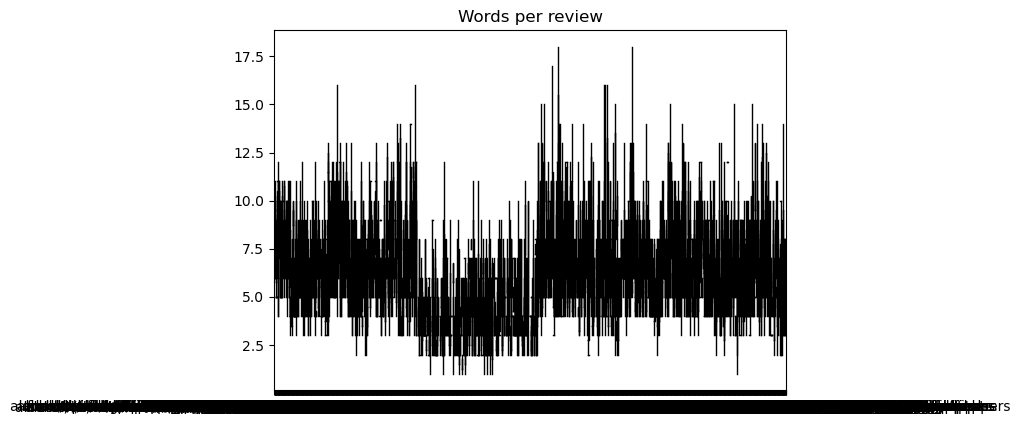

In [20]:
df["Words per review"] = df["text"].str.split().apply(len)
df.boxplot("Words per review", by="label", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [21]:
# 0 is negative
# 1 is positive
df[df.text.str.len() < 200]

,text,label,Words per review
0,Mac & Jack's Brewing Co. Marty Time Lager12 fl oz,alcohol/beer/ales/amber red ale,10
1,"Pizza Port Brewing Co. Amber Ale, Chronicale16.9 fl oz",alcohol/beer/ales/amber red ale,9
2,"Global Beer Network Beer, Gulden Draak11.2 fl oz",alcohol/beer/ales/amber red ale,8
3,Full Sail Amber Ale12 fl oz,alcohol/beer/ales/amber red ale,6
4,"Weyerbacher Ale, Blithering Idiot, Barley-Wine Style12 fl oz",alcohol/beer/ales/barley wine,8
...,...,...,...
7589,Aneto 100% Natural Fish Broth33.8 fl oz,food/pantry/soups/broths stocks/other broths,7
7590,Culinary Tours Ramen Broth32 fl oz,food/pantry/soups/broths stocks/other broths,6
7591,"Manischewitz Whitefish & Pike, Sweet, Jelled Broth24 oz",food/pantry/soups/broths stocks/other broths,8
7592,Zatarain's Shrimp Creole Base2 oz,food/pantry/soups/broths stocks/other broths,5


In [22]:
imdb.reset_format()

## Tokenizer

In [20]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-cased"
#checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

imdb_encoded = imdb.map(tokenize_function, batched=True, batch_size=None)
imdb_encoded

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 400
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 400
    })
})

In [21]:
print(imdb_encoded['train'][0])

{'text': "I was pleased to see that she had black hair! I've been a fan for about 30 years now and have been disgusted at the two earlier attempts to film the stories.<br /><br />I was pleased that the screenwriters updated the period to include a computer, it didn't spoil it at all. In fact I watched the film twice in one day, a sure sign that it was up to standard. This is what I do with books that I like as well.<br /><br />I thought all the characters were well depicted and represented the early days of Modesty Blaise extremely well as evinced in both book and comic strip. I would also have to disagree with a comment made by an earlier reviewer about baddies having to be ugly. Has he actually read the books?<br /><br />I thought this was a very good film and look forward to sequels with anticipation.", 'label': 1, 'input_ids': [101, 146, 1108, 7229, 1106, 1267, 1115, 1131, 1125, 1602, 1716, 106, 146, 112, 1396, 1151, 170, 5442, 1111, 1164, 1476, 1201, 1208, 1105, 1138, 1151, 20524,

## Tiny IMDB

In [22]:
import transformers
import re

[x for x in dir(transformers) if re.search(r'^AutoModel', x)]

['AutoModel',
 'AutoModelForAudioClassification',
 'AutoModelForAudioFrameClassification',
 'AutoModelForAudioXVector',
 'AutoModelForCTC',
 'AutoModelForCausalLM',
 'AutoModelForDepthEstimation',
 'AutoModelForDocumentQuestionAnswering',
 'AutoModelForImageClassification',
 'AutoModelForImageSegmentation',
 'AutoModelForImageToImage',
 'AutoModelForInstanceSegmentation',
 'AutoModelForKeypointDetection',
 'AutoModelForMaskGeneration',
 'AutoModelForMaskedImageModeling',
 'AutoModelForMaskedLM',
 'AutoModelForMultipleChoice',
 'AutoModelForNextSentencePrediction',
 'AutoModelForObjectDetection',
 'AutoModelForPreTraining',
 'AutoModelForQuestionAnswering',
 'AutoModelForSemanticSegmentation',
 'AutoModelForSeq2SeqLM',
 'AutoModelForSequenceClassification',
 'AutoModelForSpeechSeq2Seq',
 'AutoModelForTableQuestionAnswering',
 'AutoModelForTextEncoding',
 'AutoModelForTextToSpectrogram',
 'AutoModelForTextToWaveform',
 'AutoModelForTokenClassification',
 'AutoModelForUniversalSegmentatio

In [23]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=num_labels)
         .to(device))

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from datasets import DatasetDict

tiny_imdb = DatasetDict()
tiny_imdb['train'] = imdb['train'].shuffle(seed=1).select(range(50))
tiny_imdb['validation'] = imdb['validation'].shuffle(seed=1).select(range(10))
tiny_imdb['test'] = imdb['test'].shuffle(seed=1).select(range(10))

tiny_imdb_encoded = tiny_imdb.map(tokenize_function, batched=True, batch_size=None)
tiny_imdb_encoded

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10
    })
})

In [25]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(tiny_imdb_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-tiny-imdb"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )
training_args

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=epoch,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
f

In [26]:
from transformers import Trainer

torch.cuda.empty_cache()

trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=tiny_imdb_encoded["train"],
                  eval_dataset=tiny_imdb_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss
1,0.709700,0.693682
2,0.684700,0.691784


In [27]:
preds = trainer.predict(tiny_imdb_encoded['test'])
preds

PredictionOutput(predictions=array([[-0.07813132, -0.0218894 ],
       [-0.06051253, -0.04590895],
       [-0.0524372 , -0.03415285],
       [-0.03649085, -0.0549056 ],
       [-0.05482435, -0.01995463],
       [-0.02060993, -0.04347536],
       [-0.02315885, -0.02696504],
       [-0.05743931, -0.03777942],
       [-0.06113335, -0.03809236],
       [-0.04167246, -0.02477802]], dtype=float32), label_ids=array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0]), metrics={'test_loss': 0.6978691220283508, 'test_runtime': 0.1773, 'test_samples_per_second': 56.405, 'test_steps_per_second': 11.281})

In [28]:
preds.predictions.shape

(10, 2)

In [29]:
preds.predictions.argmax(axis=-1)

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 1])

In [30]:
preds.label_ids

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0])

In [31]:
from sklearn.metrics import accuracy_score

accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))

0.4

In [32]:
def get_accuracy(preds):
  predictions = preds.predictions.argmax(axis=-1)
  labels = preds.label_ids
  accuracy = accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))
  return {'accuracy': accuracy}


In [33]:
from transformers import Trainer

torch.cuda.empty_cache()

trainer = Trainer(model=model,
                  compute_metrics=get_accuracy,
                  args=training_args,
                  train_dataset=tiny_imdb_encoded["train"],
                  eval_dataset=tiny_imdb_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy
1,0.665700,0.686416,0.500000
2,0.637600,0.682733,0.500000


## Training run

In [49]:
batch_size = 8
logging_steps = len(imdb_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-imdb"
# model_name = f"{checkpoint}-finetuned-tiny-imdb"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [50]:
from transformers import Trainer

torch.cuda.empty_cache()

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=get_accuracy,
                  train_dataset=imdb_encoded["train"],
                  eval_dataset=imdb_encoded["validation"],
                  tokenizer=tokenizer)
# trainer = Trainer(model=model,
#                   args=training_args,
#                   compute_metrics=get_accuracy,
#                   train_dataset=tiny_imdb_encoded["train"],
#                   eval_dataset=tiny_imdb_encoded["validation"],
#                   tokenizer=tokenizer)


trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy
1,0.442400,0.402107,0.835000
2,0.251600,0.336706,0.895000


In [51]:


trainer.evaluate()

{'eval_loss': 0.3367061913013458,
 'eval_accuracy': 0.895,
 'eval_runtime': 6.1469,
 'eval_samples_per_second': 65.073,
 'eval_steps_per_second': 8.134,
 'epoch': 2.0}

In [52]:
trainer.save_model()

In [53]:
model_name

'distilbert-base-cased-finetuned-imdb'

In [54]:
from transformers import pipeline
classifier = pipeline('text-classification', model=model_name)
# classifier = pipeline('text-classification', model=model)
classifier('This is not my idea of fun')

[{'label': 'LABEL_0', 'score': 0.5104947090148926}]

In [55]:
classifier('This was beyond incredible')

[{'label': 'LABEL_1', 'score': 0.6042473912239075}]